In [1]:
# 更多示例应用
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string
import tushare as ts # Yahoo的接口不能指望了
from pandas import DataFrame, Series
from pandas.tseries.offsets import Day, Hour, Minute, MonthEnd
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
data_50 = ts.get_hist_data('510050',start='2015-01-01',end='2016-12-31')
data_180 = ts.get_hist_data('510180',start='2015-01-01',end='2016-12-31')
data_500 = ts.get_hist_data('510500',start='2015-01-01',end='2016-12-31')
data_50.index = pd.to_datetime(data_50.index)
data_180.index = pd.to_datetime(data_180.index)
data_500.index = pd.to_datetime(data_500.index)
data_50 = data_50[::-1]
data_180 = data_180[::-1]
data_500 = data_500[::-1]
data = DataFrame({'50etf': data_50['close'],
                  '180etf': data_180['close'],
                  '500etf': data_500['close']})
data[:10]

,180etf,500etf,50etf
date,,,
2015-01-05,3.298,1.513,2.622
2015-01-06,3.274,1.536,2.592
2015-01-07,3.280,1.537,2.588
2015-01-08,3.197,1.523,2.518
2015-01-09,3.198,1.515,2.524
2015-01-12,3.167,1.493,2.500
2015-01-13,3.152,1.514,2.485
2015-01-14,3.153,1.508,2.494
2015-01-15,3.260,1.533,2.586


In [3]:
data = data.asfreq('B').fillna(method='pad')
data[:10]

,180etf,500etf,50etf
date,,,
2015-01-05,3.298,1.513,2.622
2015-01-06,3.274,1.536,2.592
2015-01-07,3.280,1.537,2.588
2015-01-08,3.197,1.523,2.518
2015-01-09,3.198,1.515,2.524
2015-01-12,3.167,1.493,2.500
2015-01-13,3.152,1.514,2.485
2015-01-14,3.153,1.508,2.494
2015-01-15,3.260,1.533,2.586


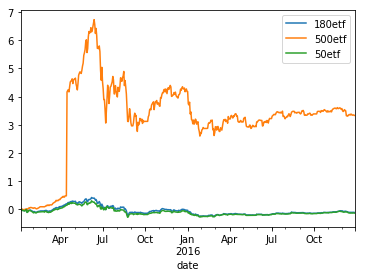

In [4]:
rets = data.pct_change()
((1 + rets).cumprod() - 1).plot()

In [5]:
def calc_mom(price, lookback, lag): # 计算动量并归一化
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.sub(ranks.mean(axis=1), axis=0) # 不能直接做数学运算
    return demeaned.div(demeaned.std(axis=1), axis=0)

In [6]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

# 通过指定回顾期和持有期（买卖之间的日数）计算投资组合整体的夏普比率。
def strat_sr(prices, lb, hold):
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [7]:
strat_sr(data, 70, 30)

-0.68843956159078112

In [8]:
dd = {}
lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
for lb in lookbacks:
    dd[lb] = {}
    for hold in holdings:
        dd[lb][hold] = strat_sr(data, lb, hold)
ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'
ddf

Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
20,-0.650342,-0.705053,-0.642323,-0.696359,-0.690524,-0.706789,-0.738852,-0.705804,-0.691543,-0.729602,-0.678131,-0.656132,-0.087592,0.122036
25,-0.706789,-0.754015,-0.714925,-0.739271,-0.751783,-0.715316,-0.644989,-0.645164,-0.696519,-0.703536,-0.678927,0.216741,0.265430,-0.389036
30,-0.719082,-0.750235,-0.712541,-0.736701,-0.724463,-0.738933,-0.715397,-0.705367,-0.665197,-0.666865,-0.688440,-0.731093,-0.752234,-0.717710
35,-0.710048,-0.685194,-0.693510,-0.660618,-0.705294,-0.642644,-0.630124,-0.639395,-0.626627,-0.634364,-0.589236,-0.609857,-0.642113,-0.685333
40,-0.723227,-0.744054,-0.712806,-0.756273,-0.718757,-0.748103,-0.741096,-0.666046,-0.705966,-0.718442,-0.675990,-0.706424,-0.374236,-0.062298
45,-0.649198,-0.656881,-0.647025,-0.658119,-0.673608,-0.677257,-0.634468,-0.607247,-0.633378,-0.667799,-0.640540,-0.637064,-0.651411,-0.664170
50,-0.676789,-0.740380,-0.687903,-0.699715,-0.692075,-0.712087,-0.647787,-0.641369,-0.689246,-0.685238,-0.633774,-0.628882,-0.628542,-0.639373
55,-0.681583,-0.683144,-0.683144,-0.702812,-0.696766,-0.728803,-0.729093,-0.649609,-0.647539,-0.654925,-0.656992,-0.654197,-0.651250,-0.649685
60,-0.688830,-0.698753,-0.689418,-0.695447,-0.737193,-0.742912,-0.707279,-0.702693,-0.641098,-0.647021,-0.647264,-0.662977,-0.661670,-0.682294


In [9]:
def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

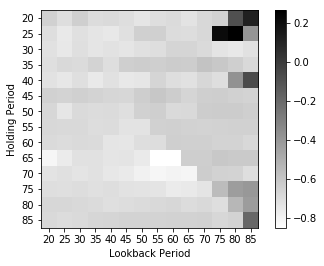

In [10]:
heatmap(ddf) # 用热力图表示上面表格

In [11]:
# 期货合约转仓
# TODO：暂时没有数据，日后再说。

In [12]:
# 移动相关系数与线性回归

In [13]:
data_50 = ts.get_hist_data('510050',start='2016-01-01',end='2017-12-31')
data_500 = ts.get_hist_data('510500',start='2016-01-01',end='2017-12-31')
data_50.index = pd.to_datetime(data_50.index)
data_500.index = pd.to_datetime(data_500.index)
data_50 = data_50[::-1]
data_500 = data_500[::-1]
data_50_close = data_50['close']
data_500_close = data_500['close']

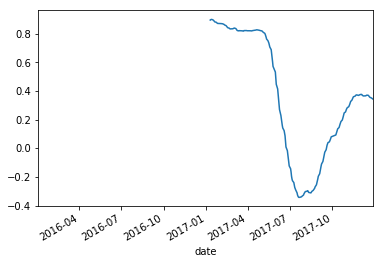

In [14]:
data_50_close.rolling(window=250).corr(data_500_close).plot()

In [15]:
def rolling(x, y, index, window): # ols被pandas抛弃了
    beta = []
    lr = LinearRegression()
    for start in range(1, len(x) - window):
        end = start + window
        x_ = DataFrame({'x': x[start:end]})
        lr.fit(x_.as_matrix(), y[start:end].as_matrix())
        beta.append(lr.coef_[0])
    return Series(beta, index=index[1: len(index) - window])

In [16]:
data_50_rets = data_50_close.pct_change()
data_500_rets = data_500_close.pct_change()
data_50_rets.head()

date
2016-01-04         NaN
2016-01-05    0.004386
2016-01-06    0.013100
2016-01-07   -0.064655
2016-01-08    0.023041
Name: close, dtype: float64

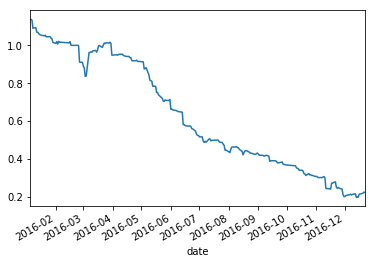

In [17]:
betas = rolling(data_50_rets, data_500_rets, data_50_rets.index, window=250)
Series(betas).plot()